In [32]:
# Uncomment to upgrade packages
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install matplotlib --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade 
# !pip install scikit-optimize --user --quiet
!pip install apafib --upgrade --user --quiet


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [33]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# Tercera lista - Problema grupal 3

## Componentes del grupo

* Pol Casacuberta Gil
* Joaquin Faraone Prieto
* Agnès Felip i Díaz
* Marta Granero i Martí

## Aprendiendo a sumar

### Aprender a sumar dos números parece un problema fácil, pero es difícil enseñárselo a una máquina a partir de ejemplos. El objetivo de este problema es probar qué tan bueno es k-vecinos más cercanos aprendiendo esta tarea.

### Vamos a limitar la tarea a aprender a sumar dos números de tres dígitos, que pueden dar como resultado un número de cuatro dígitos como máximo. Esto se puede definir como un problema de clasificación de salida múltiple. Esto significa que el clasificador devuelve una predicción que corresponde a un conjunto de clases en lugar de una sola clase.

### Vamos a definir el problema como ejemplos que tienen seis atributos, los primeros tres atributos corresponden a los tres dígitos del primer número y los últimos tres a los dígitos del segundo número. La salida tiene cuatro valores, uno para cada dígito del número del resultado de la suma. Por ejemplo:

|X1|X2|X3|X4|X5|X6|Y1|Y2|Y3|Y4|
|--|--|--|--|--|--|--|--|--|--|
|0 |1 |6 |4 |7 |7 |0 |4 |9 |3 |


## Procedemos a realizar los ejercicios que se nos piden

In [34]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB


from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit

from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from sklearn.preprocessing import KBinsDiscretizer


from apafib import load_electric_devices, load_energy

import warnings


set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
# sns.set()
pd.set_option('display.precision', 3)

In [35]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()



niter = 15
cv = 5


#### a) La primera tarea es implementar una función que genera un conjunto de datos aleatorios de sumas de dos números de tres dígitos. Aseguraos de que no haya ejemplos repetidos en el conjunto de datos.

In [36]:
data_columns = ['X1','X2','X3','X4','X5','X6','Y1','Y2','Y3','Y4']
X_columns = ['X1','X2','X3','X4','X5','X6']
y_columns = ['Y1','Y2','Y3','Y4']

In [37]:
#Function to create array
def prepareArray(number, size):
    X1 = list(map(int, str(number)))
    while len(X1) < size:
        X1.insert(0,0)
    return X1
    

def setFormat(first,second):
    total = first+second
    X1 = prepareArray(first,3)
    X2 = prepareArray(second,3)
    Y =  prepareArray(total,4)
    return X1+X2+Y

#setFormat(20,22) --Test

In [38]:
def createDataset(n):
    firsts= np.random.randint(0,1000, size=(n))
    seconds= np.random.randint(0,1000, size=(n))
    matrix = []
    
    for first, second in zip(firsts,seconds):
        matrix.append(setFormat(first,second))

    data = pd.DataFrame(matrix, columns=data_columns)
    data.drop_duplicates()
    
    return data

#### b) Generad conjuntos de datos de tamaño creciente con no más del 20 % de los ejemplos posibles en este problema. Notad que hay 10^6 ejemplos posibles. Dividid los conjuntos de datos en un conjunto de entrenamiento y test con una proporción de 90 %/10 %

In [61]:
maxEjemplos = pow(10,6)*0.2
np.random.seed(1234)

i = 25000

#Segurament no calgui tant, però ho faig tot per si ens facilita la vida en el futur
conjunto = []
trains = []
tests = [] 
X_tests = []
X_trains = []
y_tests = []
y_trains = []

while i <= maxEjemplos:
    data = createDataset(i)
    conjunto.append(data)
    train, test = train_test_split(data, test_size=0.10, random_state=42)
    X_train = train[X_columns]
    y_train = train[y_columns]
    X_test = test[X_columns]
    y_test = test[y_columns]
    
    trains.append(train)
    tests.append(test)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)
    i=i+25000


In [62]:
X_tests[1]

,X1,X2,X3,X4,X5,X6
33553,2,8,6,0,7,5
9427,0,3,0,6,2,8
199,6,1,7,9,3,9
12447,7,6,7,9,1,2
39489,2,9,9,4,5,2
...,...,...,...,...,...,...
39885,3,0,2,1,9,7
17566,1,6,0,1,2,8
16062,7,6,8,2,2,0
48445,2,6,3,8,4,3


#### c) Aplicad algún método de reducción de dimensionalidad a alguno de los conjuntos de datos de entrenamiento y comentad lo que se pueda apreciar en la visualización. Pensad en qué podéis representar sobre la transformación.

In [69]:
X_train_standarized = (X_trains[0]).copy()
y_train = y_trains[0].copy()

#scaler = StandardScaler()
#X_train_standarized[X_columns] = scaler.fit_transform(X_trains[0][X_columns])

X_train_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,22500.0,4.517,2.865,0.0,2.0,5.0,7.0,9.0
X2,22500.0,4.477,2.867,0.0,2.0,4.0,7.0,9.0
X3,22500.0,4.480,2.866,0.0,2.0,4.0,7.0,9.0
X4,22500.0,4.500,2.885,0.0,2.0,4.0,7.0,9.0
X5,22500.0,4.511,2.873,0.0,2.0,5.0,7.0,9.0
X6,22500.0,4.522,2.875,0.0,2.0,5.0,7.0,9.0


Estandarizamos los datos para que que todas las variables tengan media 0 y desviación estándar 1.

NOTA: Cal estandaritzar? En principi ja està en el mateix rang. Jo ho deixo per si de cas.)
NOTA2: casi no varia entre estandaritar i no fer-ho. 

In [73]:
myPCA = PCA().fit(X_train_standarized[X_train.columns]);

#PCA.explained_variance_ratio_ para comprender qué porcentaje de varianza explican los datos
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.17033808 0.16841352 0.16711303 0.166204   0.16510314 0.16282823]
[0.17033808 0.33875161 0.50586463 0.67206863 0.83717177 1.        ]


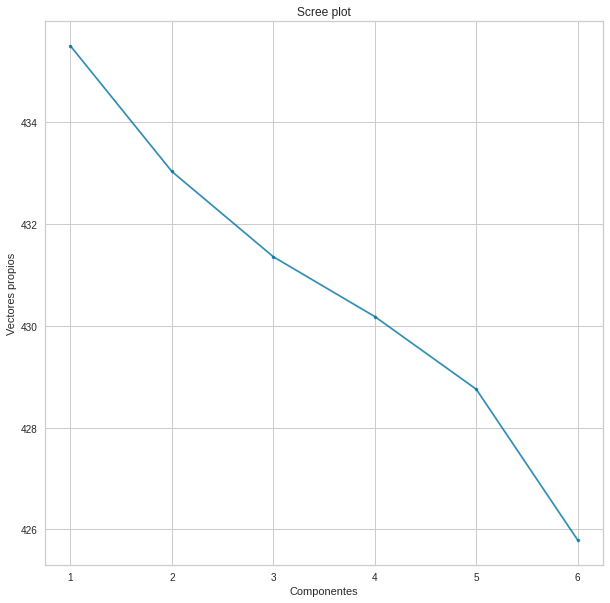

In [74]:
fig = plt.figure(figsize=(10,10));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
#La nueva base son los vectores propios de la matriz de covarianza.
y_label = plt.ylabel('Vectores propios');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

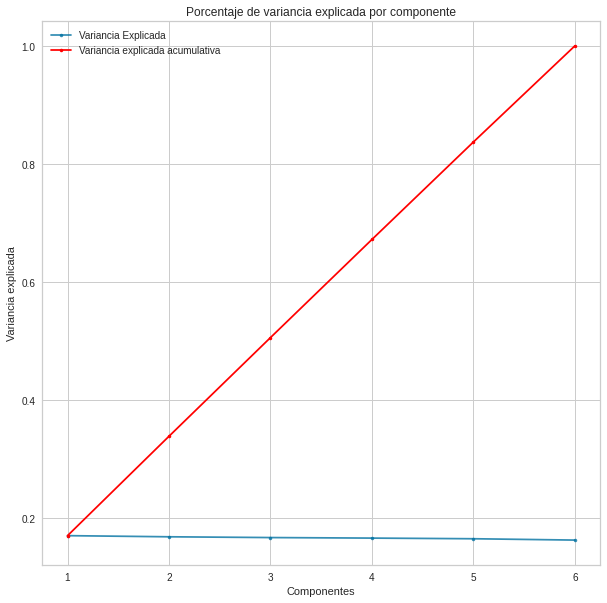

In [75]:
fig = plt.figure(figsize=(10,10));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

In [78]:
X_train_standarized

,X1,X2,X3,X4,X5,X6,PC1,PC2,PC3
4484,1,6,9,7,7,4,-2.120,-3.391,2.806
11558,0,6,4,8,6,2,0.745,-0.017,5.676
16900,3,8,5,6,2,0,-0.464,4.293,1.716
8936,9,2,9,7,6,8,1.223,-5.703,-4.748
10782,3,6,4,8,5,6,2.242,-1.802,1.578
...,...,...,...,...,...,...,...,...,...
21575,4,8,4,0,1,2,-3.510,5.723,-1.109
5390,4,2,8,3,6,8,-1.859,-4.385,-1.671
860,6,0,7,8,1,0,3.187,2.337,-0.872
15795,8,6,2,7,8,0,0.919,1.276,2.039


In [77]:
transformed_train = myPCA.transform(X_train_standarized[X_columns])
transformed_train

X_train_standarized[['PC1','PC2','PC3']] = transformed_train[:,:3]

fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', data=X_train_standarized, hue=y_train)

array([[-2.12033425, -3.39058257,  2.80592614,  1.71529021, -3.16550764,
         3.31730903],
       [ 0.74480164, -0.01656903,  5.67557723,  1.84931177, -2.3411931 ,
         1.45326091],
       [-0.46366969,  4.29322079,  1.71592735,  2.25693189, -3.76129908,
         1.77517155],
       ...,
       [ 3.18729453,  2.33715396, -0.87243554, -4.68164145, -3.34749408,
         4.91039178],
       [ 0.91888575,  1.27647656,  2.03934279, -2.2980354 , -5.08545139,
        -4.65771977],
       [-6.16752606, -4.1152967 , -3.88317059,  2.59812597, -1.1923688 ,
        -2.31104215]])

ValueError: Data must be 1-dimensional

<Figure size 576x576 with 0 Axes>

#### d) Para poder trabajar con la clasificación de salida múltiple, debéis usar el objeto $\texttt{MultiOutputClassifier}$de $\texttt{scikit learn}$. Esto envolverá el modelo clasificador k-vecinos más cercanos para que pueda realizar este tipo de clasificación. 

#### Tenéis básicamente tres hiperparámetros que podéis explorar. El número de vecinos (no tiene que ser exhaustivo, pero aseguraos de probar diferentes posibilidades y no seáis tímidos con el número de vecinos), la distancia utilizada para calcular los vecinos (encontraréis diferentes distancias disponibles en la documentación de K-nn) y si se utiliza la distancia para promediar las decisiones de los vecinos. Ajustad estos hiperparámetros para encontrar el clasificador K-nn con el mejor rendimiento para cada conjunto de datos.

#### Llevará demasiado tiempo realizar la validación cruzada, así que ajustad los parámetros utilizando la puntuación obtenida por el conjunto de test. Utilizad también el parámetro $\texttt{n_jobs=-1}$ para la clasificación K-nn y multisalida, de modo que pueda aprovechar el cálculo multinúcleo4. 

#### Explicad las cosas que habéis intentado y los resultados, no deis solo los mejores resultados. Tratad de dar una explicación sobre por qué algunas opciones tienen un mejor rendimiento que otras.

#### e) A veces usar una representación diferente para los atributos facilita la tarea de aprendizaje. Dado que en realidad tenemos atributos categóricos que corresponden a los dígitos de los números, podemos codificarlos utilizando una codificación one hot. Transformad los atributos del conjunto de datos y calculad la precisión de los mejores hiperparámetros para cada conjunto de datos y comparad su precisión con los resultados anteriores. Representad la precisión del mejor clasificador para cada representación y tamaño de conjunto de datos. Comentad los resultados e intentad explicar lo que ha sucedido.

#### f) ¿Por qué creéis que esta tarea es difícil de aprender? ¿Sería más fácil si en lugar de resolverlo como un problema de clasificación de múltiples salidas usamos la suma como la clase para predecir?